In [1]:
import geopandas as gpd
from shapely.strtree import STRtree
import networkx as nx
from shapely.ops import unary_union
from src.constants import GWS_DATA_DIR, PREFERRED_CRS
veg_data = gpd.read_file(GWS_DATA_DIR / "chernobyl_habitat_data" / "Vegetation_mape.shp")
from src.models.geograph import GeoGraph
from itertools import zip_longest
import copy

In [2]:
geog = GeoGraph(veg_data, crs=PREFERRED_CRS, columns_to_rename={"Vegetation": "class_label"}, tolerance=0.0)

Step 1 of 2: Creating nodes and finding neighbours: 100%|██████████| 14910/14910 [00:28<00:00, 518.28it/s]
Step 2 of 2: Adding edges: 100%|██████████| 14910/14910 [00:00<00:00, 44249.50it/s]Graph successfully loaded with 14910 nodes and 39590 edges.



In [3]:
list(geog.rtree.query(geog.df.geometry[0]))

[7735, 7426, 3772, 8348, 0, 10852, 2863, 434]

In [7]:
%%time
#geog.add_habitat(name="Bear", valid_classes={1, 2, 3, 4, 5, 6, 77}, max_travel_distance=5.0, dist=True)
#geog.add_habitat(name="Tiger", valid_classes={1, 2, 3, 4, 5, 6, 77}, max_travel_distance=5.0, dist=False)
geog.add_habitat(name="Bear", valid_classes={1, 2, 3, 4, 5, 6, 77}, max_travel_distance=10.0, add_distance=False)

Generating habitat graph: 100%|██████████| 14910/14910 [00:02<00:00, 5429.15it/s] 
Habitat successfully loaded with 4272 nodes and 8939 edges.
CPU times: user 19.2 s, sys: 1.44 s, total: 20.6 s
Wall time: 20.6 s


In [8]:
geog.habitats

{'Bear': Habitat(name='Bear', graph=<networkx.classes.graph.Graph object at 0x7fc3acb803d0>, valid_classes={1, 2, 3, 4, 5, 6, 77}, max_travel_distance=10.0, add_distance=False)}

In [15]:
tst.head()

0    POLYGON ((547928.819 5710697.917, 547937.773 5...
1    POLYGON ((550979.173 5711149.750, 551009.309 5...
2    POLYGON ((594253.728 5711098.733, 594253.771 5...
3    POLYGON ((595635.124 5712691.900, 595635.213 5...
4    POLYGON ((595986.015 5712816.669, 595986.097 5...
dtype: geometry

In [5]:
lynx_gdf, lynx_comps = geog.get_graph_components(geog.habitats["Lynx"])

In [8]:
geog.merge_nodes(node_list=list(lynx_comps[10]), class_label=5, final_index=12)

In [3]:
geom = veg_data.geometry.tolist()
# build dict mapping hashable unique object ids for each polygon to their index in geom
id_dict = {id(poly):index for index, poly in enumerate(geom)}
# build Rtree from geometry
tree = STRtree(geom)

In [4]:
graph_dict = {}
G = nx.Graph()
for index, polygon in enumerate(geom):
    # find the indexes of all polygons which touch the borders of or overlap with this one
    neighbours = [id_dict[id(nbr)] for nbr in tree.query(polygon) if nbr.touches(polygon) or nbr.overlaps(polygon)]
    # this dict maps polygon indices in veg_data to a list of neighbouring polygon indices
    graph_dict[index] = neighbours
    row = veg_data.loc[index]
    # add each polygon as a node to the graph, with the landcover class, area, and full polygon object as node attributes
    G.add_node(index, landcover=row['Vegetation'], area=row['AREA'], geometry=polygon)

In [5]:
for polygon_id, neighbours in graph_dict.items():
    for neighbour_id in neighbours:
        G.add_edge(polygon_id, neighbour_id)

In [6]:
print(G.number_of_nodes(), G.number_of_edges())

14910 39562


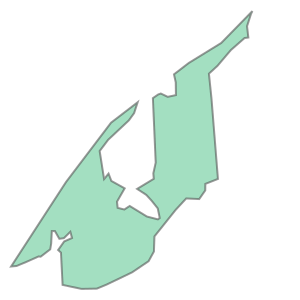

In [17]:
G.nodes[0]['geometry']

In [15]:
for node in G.nodes:
    print(node)
    print(G.adj[0])
    break

0
{7735: {}, 10852: {}, 434: {}}


True

In [16]:
G[0]

AtlasView({7735: {}, 10852: {}, 434: {}})